<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Bayesian Estimation with `pymc3`

_Authors: Kiefer Katovich (SF)_

---

### Learning Objectives
- Use pymc3 to fit Bayesian estimation models
- Run the Bayesian alternative to a t-test using pymc3
- Plot and interpret the results of pymc3 models


### Lesson Guide
- [Introduction](#intro)
- [Enter `pymc3`](#pymc3)
- [Load the Starcraft data](#data)
- [Alternative to t-testing using Bayesian estimation](#ttest)
    - [Get the APM values for 19 and 26 year olds](#load)
    - [Perform a Frequentist t-test of the mean APM difference between groups.](#freq-ttest)
    - [Set up a Bayesian model with priors on the mean APMs](#priors)
    - [Construct the prior distributions on the means](#construct-priors)
    - [Construct the prior distributions on the standard deviations](#std-priors)
    - [Set up the APM distributions for the two groups](#apm-dists)
    - [Tracking additional metrics](#metrics)
    - [Fitting the `pymc3` model](#fit)
    - [Plotting the posteriors and metric distributions](#plotting)
- [Bayesian regression with `pymc3`](#reg)
    - [Set up variables to perform an age vs. APM regression](#age-vs-apm)
    - [Set up the Bayesian regression model](#bayes-model)
    - [Plot the posteriors using `pm.traceplot`](#traceplot)
- [Using a patsy-style formula to specify a `pymc3` model](#formula)

<a id='intro'></a>
## Introduction
---

With `pymc3` we can perform the Bayesian counterparts of Frequentist models we have studied. In this codealong lesson we will start incrementally: first by repeating the Beta-Binomial model from yesterday, then replacing the Frequentist t-test with Bayesian estimation and finally performing a Bayesian regression with a single predictor.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='data'></a>
### Load the Starcraft dataset
---

You may be familiar with this dataset. It has records of different player statistics in competitive Starcraft. There are a variety of columns that are described in detail within the `description.txt` file contained inside the `./datasets/` folder.

For the examples in this lab, I will be using APM (actions per minute) and Age, but I in the following lab you will get the chance to look at other variables as well.

In [7]:
star = pd.read_csv('../datasets/SkillCraft1_Dataset.csv')

In [8]:
star.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


<a id='ttest'></a>
## Alternative to t-testing using Bayesian estimation
---

[This example is adapted from the documentation here.](http://pymc-devs.github.io/pymc3/notebooks/BEST.html) 

> *Note: In that example the Student t distribution is used instead of the normal distribution like I use below. This is more appropriate, but more complicated due to the parameterization of the t-distribution. If you're feeling bold try doing this with the t-distribution like in the documentation!

In the following code, I will be using Bayesian posterior estimation to look at the difference in APM between 19 year old players and 26 year old players.

### The Frequentist strategy
In Frequentist statistics, calculating the mean difference between groups is typically done with a t-test. In a t-test we state a null hypothesis (H0) that there is no diffference between groups, then evaluate the probability that we could have gotten this data when the null hypothesis is true.

The de-facto standard for statistically comparing two (or more) samples is to use a statistical test. This involves expressing a null hypothesis, which typically claims that there is no difference between the groups, and using a chosen test statistic to determine whether the distribution of the observed data is plausible under the hypothesis. This rejection occurs when the calculated test statistic is higher than some pre-specified threshold value.

### The Bayesian strategy
The Bayesian approach for evaluating differences between groups is "estimation" rather than "testing". Instead of asking "are the two groups different?", we instead ask "_how_ different are the two groups?" This is the subtle difference in estimation as opposed to testing. We are measuring the extent of the difference between the groups, whether it be zero or any other value.

For a more detailed treatment feel free to read the documentation linked above.

<a id='load'></a>
### Get the APM for 19 and 26 year olds

In [9]:
apm19 = star[star.Age == '19'].APM.values
apm26 = star[star.Age == '26'].APM.values

In [10]:
print(apm19.shape, apm26.shape)

(313,) (136,)


**Calculate the mean for the two groups and the empirical difference between means.**

In [11]:
print(apm19.mean(), apm26.mean(), apm26.mean()-apm19.mean())

121.68955974440894 104.74184073529412 -16.94771900911482


<a id='freq-ttest'></a>
### Perform a Frequentist t-test of the mean APM difference between groups.

What is the null hypothesis? What is the alternative hypothesis?

In [12]:
import scipy.stats as stats

In [13]:
# The null hypothesis is that there is zero difference between the mean APM.
# The alternative hypothesis is that there IS a difference.

In [14]:
tt = stats.ttest_ind(apm19, apm26)

In [15]:
tt.statistic

3.5501270512716077

**Plot the t-statistic for the test on the t-distribution.**

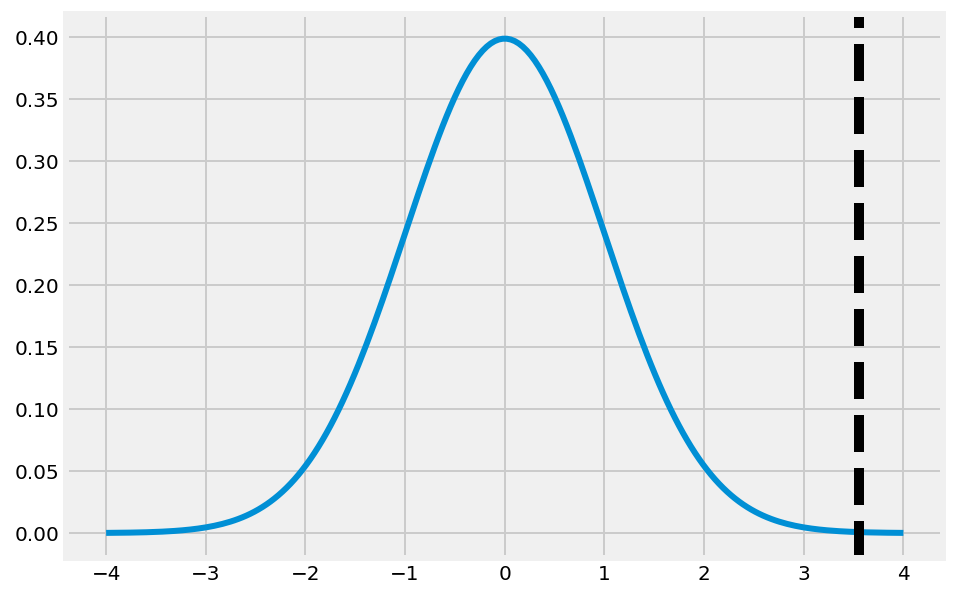

In [16]:
tdist = stats.t(df=len(apm19)+len(apm26)-2)
xvals = np.linspace(-4, 4, 200)

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(xvals, tdist.pdf(xvals), lw=3)
ax.axvline(tt.statistic, color='black', ls='dashed', lw=5)
plt.show()

**What is the p-value?**

In [17]:
1. - tdist.cdf(tt.statistic)

0.00021293463976312932

In [18]:
tt.pvalue  # two-tailed

0.00042586927952623034

<a id='priors'></a>
### Set up the bayesian model with priors on mean APMs

Next we'll go through the steps of the Bayesian estimation of the difference between means using `pymc3`.

First we find the mean and standard deviation of APM regardless of age group. We can going to use these values to inform our prior belief about APM.

In [19]:
prior_mean = star.APM.mean()
prior_std = star.APM.std()

print(prior_mean, prior_std)

117.04694709278338 51.94529098683481


<a id='construct-priors'></a>
### Construct the prior distributions on the means

> **Note**: `pymc3` sets up models using the Python `with ... :` syntax.

The first thing we are going to set up is our prior belief about the mean APM for our 19 year olds and 26 year olds. _These are not fixed values,_ but rather normal distributions covering a range of possible values for the mean APM for each group with varying likelihoods.

We are going to set up the normal distributions to both take the overall mean and standard deviation of the actions per minute for all players. In other words, our prior belief for each group's mean APM is the same.

> Note that we are really creating to Bayesian models at once!

In [20]:
with pm.Model() as model:
    
    group19_mean = pm.Normal('APM_19yo_mean', prior_mean, sd=prior_std)
    group26_mean = pm.Normal('APM_26yo_mean', prior_mean, sd=prior_std)
    
    

<a id='std-priors'></a>
### Priors on standard deviations

What we set up before are the prior distributions for the _means_ of APM for the two age groups, but we can also set up priors on the standard deviations for APM for each group.

Our standard deviation priors can be "uninformative": uniformly distributed from close to 0 up to 100. We are saying that we believe all standard deviations in those ranges to be equally likely.

In [21]:
prior_std_lower = 0.00001
prior_std_upper = 100.

with model:
    
    group19_std = pm.Uniform('APM_19yo_std', lower=prior_std_lower, upper=prior_std_upper)
    group26_std = pm.Uniform('APM_26yo_std', lower=prior_std_lower, upper=prior_std_upper)
    

<a id='apm-dists'></a>
### Set up the APM distributions for the two groups

Now that we have our prior beliefs about the mean and standard deviation of APM for each age group, we can construct what will be the posterior distributions for the APMs after "observing" the data.

For each group we set up a `pm.Normal` distribution to represent the likelihood of the observed APM data. The mean `mu=` will be our prior belief distribution of the mean for that group. Likewise the `sd=` will be the prior distribution for standard deviation of APM for that group. 

Lastly, we provide the vectors of data for the `observed=` parameter. This is the actual, measured APM data. When we "fit" this model (using MCMC or another sampling strategy under the hood), the posterior distributions will be updated according to our prior beliefs and our data – just like in Bayes formula!

In [22]:
with model:
    group19 = pm.Normal('APM_19yo', mu=group19_mean, sd=group19_std, observed=apm19)
    group26 = pm.Normal('APM_26yo', mu=group26_mean, sd=group26_std, observed=apm26)
    

<a id='metrics'></a>
### Tracking additional metrics

The last thing we'll do before fitting the model is define some distributions that will make it easier for us to evaluate the difference between mean APMs of the two groups. 

`pm.Deterministic` distributions are defined from other distributions in the model. For example, we can set up `diff_of_means` to be defined by `group19_mean - group26_mean`, making this a distribution of the differences between means between groups as the posteriors are iteratively fit/estimated.

In [23]:
with model:
    diff_of_means = pm.Deterministic('mean_diff', group19_mean - group26_mean)
    diff_of_stds = pm.Deterministic('std_diff', group19_std - group26_std)

<a id='fit'></a>
### Fitting the `pymc3` model

When we call `trace = pm.sample(...)` we are starting a sampling process to estimate the posterior distribution. `pymc3` has the option to do MCMC, but defaults to the NUTS sampler. NUTS stands for No U-Turn Sampler and is a state-of-the-art posterior estimation algorithm.

The "trace" is a collection of all the values on the posterior distribution "visited" during the sampling procedure. The values in the trace define the posterior distribution.

In [24]:
with model:
    trace = pm.sample(25000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [APM_26yo_std_interval__, APM_19yo_std_interval__, APM_26yo_mean, APM_19yo_mean]
100%|██████████| 25500/25500 [00:21<00:00, 1202.75it/s]


<a id='plotting'></a>
### Plotting the posteriors and metric distributions

`pymc3` comes with convenient methods for plotting posteriors. Below we plot our posterior means and standard deviations. The relevant statistics about the distributions are automatically added to the plots.

The HPD is the Highest Posterior Density interval. This gives us a Bayesian "credible interval" which is the corollary to the Frequentist confidence interval. The 95% HPD says that the 95% highest density points on the distribution fall within that range.

**Take a look at the first element of the `trace`:**

In [25]:
trace[0]

{'APM_19yo_mean': 122.94866744090523,
 'APM_26yo_mean': 105.15577023765292,
 'APM_19yo_std_interval__': -0.04245151228424088,
 'APM_26yo_std_interval__': -0.3512103991425766,
 'APM_19yo_std': 48.93887665191823,
 'APM_26yo_std': 41.30889919404014,
 'mean_diff': 17.79289720325231,
 'std_diff': 7.629977457878091}

**Use the `pm.plot_posterior` function to look at the posterior distributions for the group means and standard deviations.**

> **Note:** It is common to slice off the initial portion of the trace. This is known as the "burn-in". The sampling procedure often starts far away from the correct estimates, and so slicing off the beginning can get rid of the cruft. It is also common to not take every sample, but skip every two or three. I am not doing that here.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1178e1080>,
      dtype=object)

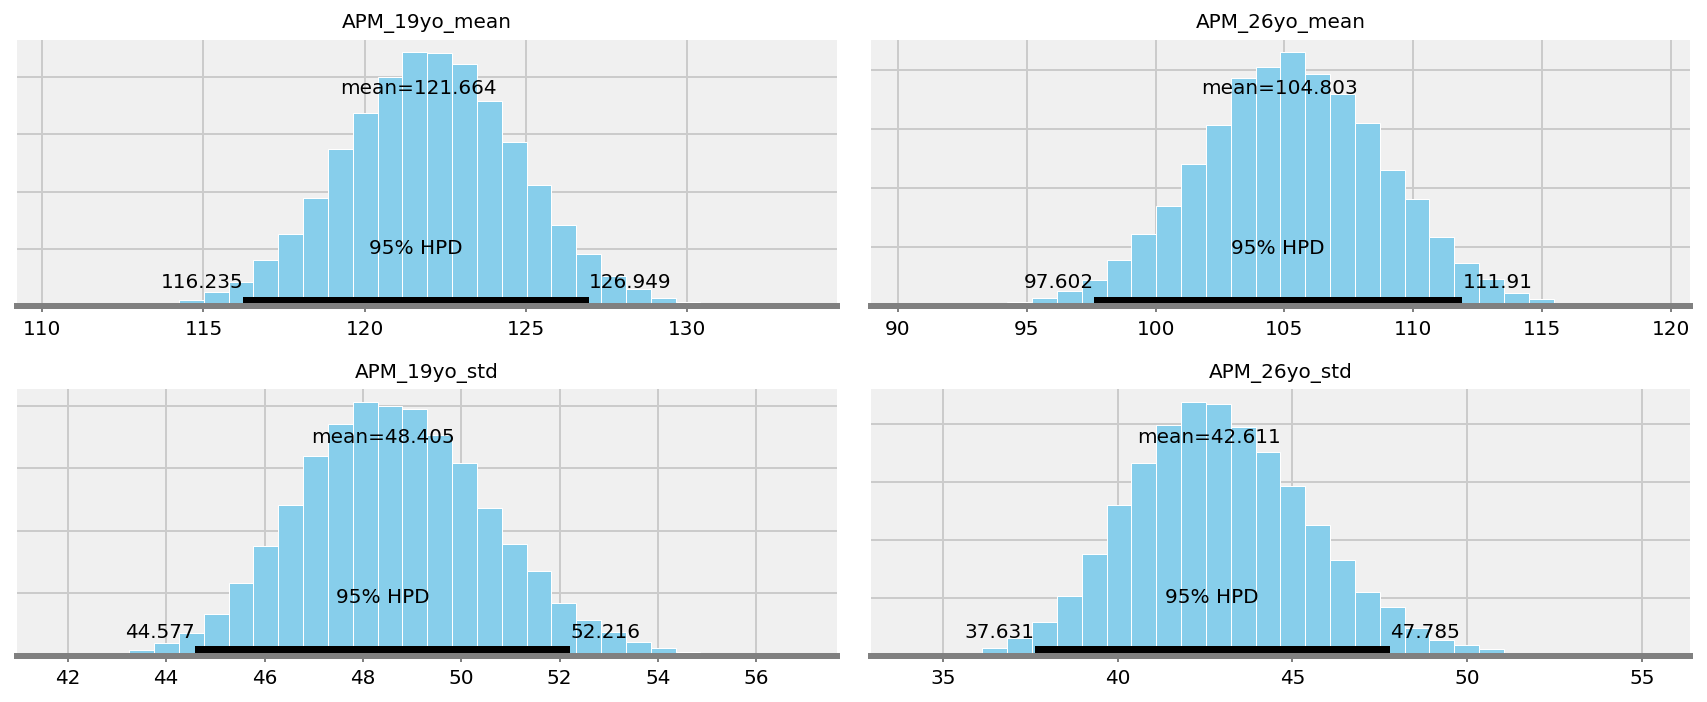

In [26]:
pm.plot_posterior(trace[5000:],
                  varnames=['APM_19yo_mean', 'APM_26yo_mean',
                            'APM_19yo_std', 'APM_26yo_std'],
                 color='#87ceeb')

**Check**  Relate these distributions to the _sampling distribution_.

**Plot the posteriors of our metric distributions.**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x119349ef0>,
      dtype=object)

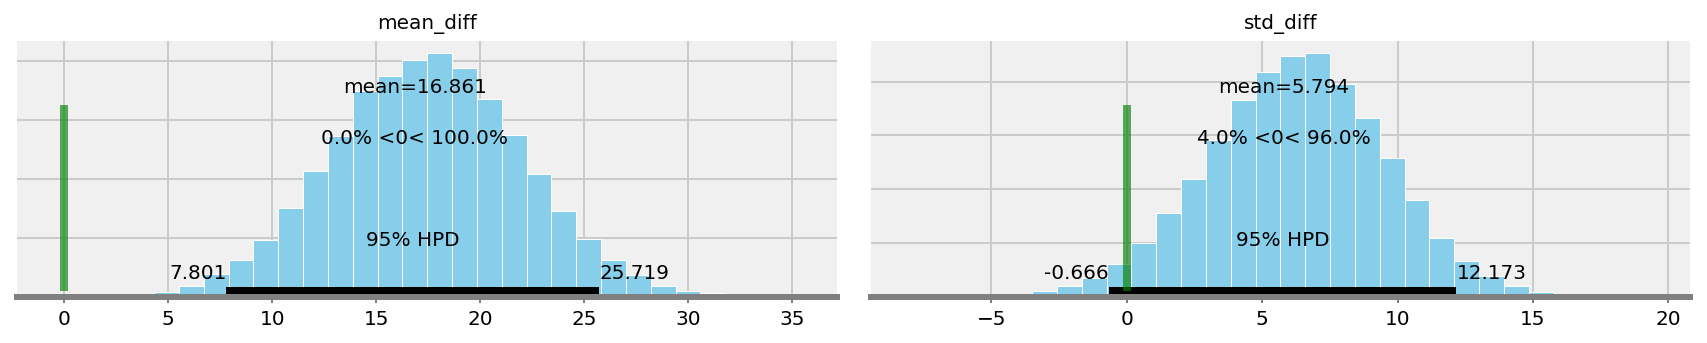

In [27]:
pm.plot_posterior(trace[5000:],
                  varnames=['mean_diff', 'std_diff'],
                  color='#87ceeb', ref_val=0)

**The `pm.summary` function can also display a text representation of this information:**

In [28]:
pm.summary(trace[5000:],varnames=['mean_diff', 'std_diff'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean_diff,16.860768,4.575222,0.019424,7.800648,25.719319,62007.327349,0.999977
std_diff,5.793945,3.264032,0.012462,-0.666288,12.172638,56936.058507,0.999982
